In [1]:
# Install packages
!pip install geopandas
!pip install pysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from pandas.core.frame import DataFrame
import csv

import geopandas as gpd
import networkx as nx
from pysal.lib import weights
from pysal.lib import cg as geometry

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/conda/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See h

In [3]:
# 将California_ct.csv转换为字典，key为full_ct_fips，value为剩余属性
f = open('/kaggle/input/california-census-tract/California_ct.csv','r',encoding='utf8')
# 属性值
attr = ['pop_total','sex_total','sex_male','sex_female','age_median','households','race_total','race_white',
        'race_black','race_native','race_asian','inc_total_pop','inc_no_pop','inc_with_pop','inc_pop_10k',
        'inc_pop_1k_15k','inc_pop_15k_25k','inc_pop_25k_35k','inc_pop_35k_50k','inc_pop_50k_65k','inc_pop_65k_75k',
        'inc_pop_75k','inc_median_ind','travel_total_to_work','travel_driving_to_work','travel_pt_to_work',
        'travel_taxi_to_work','travel_cycle_to_work','travel_walk_to_work','travel_work_from_home','edu_total_pop',
        'bachelor_male_25_34','master_phd_male_25_34','bachelor_male_35_44','master_phd_male_35_44','bachelor_male_45_64',
        'master_phd_male_45_64','bachelor_male_65_over','master_phd_male_65_over','bachelor_female_25_34',
        'master_phd_female_25_34','bachelor_female_35_44','master_phd_female_35_44','bachelor_female_45_64',
        'master_phd_female_45_64','bachelor_female_65_over','master_phd_female_65_over','edu_total','edu_bachelor',
        'edu_master','edu_phd','inc_median_household','inc_per_capita','employment_total_labor','employment_employed',
        'employment_unemployed','housing_units_total','housing_units_occupied','housing_units_vacant',
        'rent_median','property_value_total','property_value_median','vehicle_total_imputed','state','state_fips',
        'county_fips','tract_fips','household_size_avg','sex_male_ratio','race_white_ratio',
        'race_black_ratio','race_native_ratio','race_asian_ratio','travel_driving_ratio','travel_pt_ratio',
        'travel_taxi_ratio','travel_cycle_ratio','travel_walk_ratio','travel_work_home_ratio','edu_bachelor_ratio',
        'edu_master_ratio','edu_phd_ratio','edu_higher_edu_ratio','employment_unemployed_ratio',
        'vehicle_per_capita','vehicle_per_household','vacancy_ratio']
print(len(attr))
# 通过fieldnames参数指定字段
reader = csv.DictReader(f)
head_row = next(reader) # next()方法用于移动指针
california_ct_dict = {}

for line in reader:
    geoid = int(line['full_ct_fips'])
    california_ct_dict[geoid] = {}
    for i in attr:
        california_ct_dict[geoid][i] = line[i]

# e.g.
print(california_ct_dict[6085512021]) # 一个geoid对应一条记录

87
{'pop_total': '6491.0', 'sex_total': '6491.0', 'sex_male': '3308.0', 'sex_female': '3183.0', 'age_median': '41.2', 'households': '2082.0', 'race_total': '6491.0', 'race_white': '3331.0', 'race_black': '275.0', 'race_native': '74.0', 'race_asian': '1748.0', 'inc_total_pop': '5219.0', 'inc_no_pop': '820.0', 'inc_with_pop': '4399.0', 'inc_pop_10k': '608.0', 'inc_pop_1k_15k': '207.0', 'inc_pop_15k_25k': '309.0', 'inc_pop_25k_35k': '409.0', 'inc_pop_35k_50k': '583.0', 'inc_pop_50k_65k': '653.0', 'inc_pop_65k_75k': '100.0', 'inc_pop_75k': '1530.0', 'inc_median_ind': '51546.0', 'travel_total_to_work': '3420.0', 'travel_driving_to_work': '3296.0', 'travel_pt_to_work': '16.0', 'travel_taxi_to_work': '0.0', 'travel_cycle_to_work': '0.0', 'travel_walk_to_work': '6.0', 'travel_work_from_home': '102.0', 'edu_total_pop': '4977.0', 'bachelor_male_25_34': '205.0', 'master_phd_male_25_34': '63.0', 'bachelor_male_35_44': '187.0', 'master_phd_male_35_44': '90.0', 'bachelor_male_45_64': '237.0', 'maste

In [4]:
def get_attr_val(g_id, column_name): # 根据geoid以及属性名返回相应的属性值
    # geoid = int((fn.split('.')[0]).split('_')[1])
    # print(geoid)
    if g_id in california_ct_dict: # 判断geoid是否在字典中
        val = float(california_ct_dict[g_id][column_name]) # 在的话根据属性名取出对应的值
    else:
        val = 0 # 不在默认属性值为0
    # print(val)
    return val

In [5]:
# 获取数据集以及标签
X_list = []  # 图片路径
Y_list = []  # 每一张图片对应的geoid
for dirname, _, filenames in os.walk('/kaggle/input/california-satellite-imagery/satellite imagery labeled'):
    for filename in filenames:
        X_list.append(os.path.join(dirname, filename))
        geoid = int((filename.split('.')[0]).split('_')[1]) # 从图片名中取出geoid
        Y_list.append(geoid)

print(len(X_list))
print(len(Y_list))

9129
9129


In [6]:
# 划分对应的训练集和测试集 70%为训练集 30%为测试集
X_train, X_test, y_train, y_test = train_test_split(X_list, Y_list, test_size=0.3, random_state=0)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


6390
2739
6390
2739


In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels
        self.transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 读入路径 打开图片
        file = self.files[idx]
        img = Image.open(file)
        img=img.convert("RGB")

        # 重置图片大小 转换为张量
        img = self.transform(img)

        # 提取label 包括geoid以及对应的属性值
        label = []
        geoid = self.labels[idx]
        label.append(geoid)
        attr = get_attr_val(geoid, 'property_value_median')/10000
        label.append(attr)

        # print(img, label)
        return img, label

In [8]:
# 创建训练集验证集测试集
train_dataset = SatelliteDataset(X_train, y_train)
test_dataset = SatelliteDataset(X_test, y_test)

# 决定batch size大小
train_batch_size = 128
test_batch_size = 1

# dataloader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# alexnet
alexnet = models.alexnet(pretrained=True)

# 把原模型最后一层全连接层替换掉
alexnet.classifier = nn.Sequential()

# 全连接层最终out_features=1
bi_classifier = nn.Sequential(
     nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=1, bias=True),

)

alexnet.classifier = bi_classifier

alexnet.to(device)

# 全部重新训练 所有权重都需要在训练时进行更新
parameters_alexnet=[]
for name, param in alexnet.named_parameters():
    print(name)
    param.requires_grad = True
    parameters_alexnet.append(param)
#     if('classifier' in name):
# #         print(name)
#         param.requires_grad = True
#         parameters_alexnet.append(param)
#     else:
#         param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]  


features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


In [11]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
# 训练
# 损失函数 优化方法
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=parameters_alexnet, lr=0.001)

# epoch
epochs = 50


In [13]:
# 用于作图
t_loss = []
v_loss = []
# 训练模式
alexnet.train()
# 开始训练
for epoch in range(epochs):
    epoch_train_loss = 0
    for data, label in train_loader:
        data = data.to(device)
        #label[0]是geoid 
        #label[1]是batch中图片对应的property_value_median用于loss计算 
        attrs = label[1] 
        attrs = attrs.to(device)
        attrs = attrs.type(torch.float) # 转换为float
        output = alexnet(data)  # forward
        attrs = attrs.unsqueeze(1)
        loss = criterion(output, attrs)  # 计算loss mseLoss

        optimizer.zero_grad()
        loss.backward()  # backward
        optimizer.step()  # 更新参数 AdamW

        epoch_train_loss += (loss.item())/len(train_loader)
    

    print('Epoch : {},  train loss : {}'.format(epoch+1,epoch_train_loss))
    t_loss.append(epoch_train_loss)

    # 验证
    alexnet.eval()
    with torch.no_grad():
        epoch_test_loss =0

        for data, label in test_loader:
            data = data.to(device)
            attrs = label[1]
            attrs = attrs.to(device)
            attrs = attrs.type(torch.float)
            attrs = attrs.unsqueeze(1)

            test_output = alexnet(data)  # forward
            test_loss = criterion(test_output,attrs)  # 计算loss

            epoch_test_loss += test_loss/ len(test_loader)
            

        print('Epoch : {} , validation loss : {}'.format(epoch+1,epoch_test_loss))
        v_loss.append(epoch_test_loss)

Epoch : 1,  train loss : 3906.521529541016
Epoch : 1 , validation loss : 1681.9609375
Epoch : 2,  train loss : 1451.2174157714849
Epoch : 2 , validation loss : 1482.2039794921875
Epoch : 3,  train loss : 1361.61900390625
Epoch : 3 , validation loss : 1475.2452392578125
Epoch : 4,  train loss : 1405.9225573730469
Epoch : 4 , validation loss : 1437.3638916015625
Epoch : 5,  train loss : 1287.1610839843752
Epoch : 5 , validation loss : 1363.4959716796875
Epoch : 6,  train loss : 1209.9216125488283
Epoch : 6 , validation loss : 1405.66552734375
Epoch : 7,  train loss : 1178.0123266601563
Epoch : 7 , validation loss : 1404.51123046875
Epoch : 8,  train loss : 1139.6950610351562
Epoch : 8 , validation loss : 1261.0694580078125
Epoch : 9,  train loss : 1113.7581396484377
Epoch : 9 , validation loss : 1238.203857421875
Epoch : 10,  train loss : 1085.0258544921876
Epoch : 10 , validation loss : 1269.5802001953125
Epoch : 11,  train loss : 1111.3138513183592
Epoch : 11 , validation loss : 1203.1

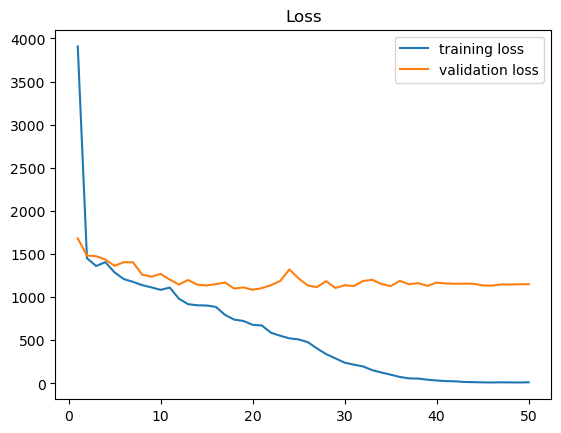

In [23]:
# loss图
import matplotlib.pyplot as plt
# import numpy as np
x = [ i for i in range(1, 51)]
t_loss = [3906.521529541016, 1451.2174157714849, 1361.61900390625, 1405.9225573730469, 
          1287.1610839843752, 1209.9216125488283, 1178.0123266601563, 1139.6950610351562, 
          1113.7581396484377, 1085.0258544921876, 1111.3138513183592, 981.536748046875, 
          918.542314453125, 906.3158666992189, 903.5196240234376, 887.1760400390626, 
          795.4670227050782, 739.7974658203127, 724.2549658203127, 679.8570355224609, 
          671.9825689697267, 587.7672540283204, 552.7538385009765, 522.8337384033204, 
          510.23056091308587, 478.71626831054687, 405.47155883789065, 339.4797744750977, 
          290.5429556274414, 240.95972839355466, 217.70318969726557, 197.1886538696288, 
          154.11703979492182, 126.4163981628418, 101.82425903320315, 75.0466522979736, 
          58.502915191650395, 56.3454648590088, 43.24129356384276, 34.07925746917724, 
          27.209084739685057, 24.598915367126466, 17.373289489746092, 14.825361957550049, 
          12.290471534729003, 11.151126270294188, 12.995229997634887, 11.844834985733035, 
          11.167904529571533, 13.219527759552001]
v_loss = [1681.9609375, 1482.2039794921875, 1475.2452392578125, 1437.3638916015625, 
          1363.4959716796875, 1405.66552734375, 1404.51123046875, 1261.0694580078125, 
          1238.203857421875, 1269.5802001953125, 1203.161376953125, 1147.209228515625, 
          1199.0850830078125, 1144.2880859375, 1136.5989990234375, 1150.74169921875, 
          1170.4443359375, 1100.54736328125, 1113.0870361328125, 1085.647705078125, 
          1104.8204345703125, 1138.9464111328125, 1187.838623046875, 1321.957763671875, 
          1217.0689697265625, 1135.071533203125, 1117.8587646484375, 1185.7427978515625, 
          1106.5833740234375, 1138.8302001953125, 1128.810302734375, 1187.1552734375, 
          1201.466064453125, 1152.1046142578125, 1127.8421630859375, 1189.4393310546875, 
          1149.286865234375, 1163.1986083984375, 1130.87060546875, 1169.0904541015625, 
          1158.9300537109375, 1155.697021484375, 1156.8760986328125, 1155.9393310546875, 
          1136.441650390625, 1134.0286865234375, 1147.490478515625, 1146.991943359375, 
          1149.39501953125, 1150.950439453125]
# print(len(t_loss))
# print(len(v_loss))
l1,=plt.plot(x, t_loss)
l2,=plt.plot(x, v_loss)
plt.title("Loss")
plt.legend(handles = [l1, l2,], labels = ['training loss', 'validation loss'], loc='best') 
plt.show()


In [24]:
# 用训练好的模型 输入卫星图像 预测property value median
all_dataset = SatelliteDataset(X_list, Y_list)
# dataloader
all_loader = DataLoader(all_dataset, batch_size=1)
# print(Y_list)

In [25]:
alexnet.eval()
lb = []
predicted = []
actual = []
with torch.no_grad():
    for data, label in all_loader:
        data = data.to(device)

        for ll in label[0]:
            lb.append(ll.item())
        for v in label[1]:
            actual.append(v.item())

        test_output = alexnet(data)
        predicted.append(test_output.item()*10000)
print(len(predicted))
print(len(lb))
print(len(actual))

9129
9129
9129


In [34]:
# 评估模型效果 计算MSE以及r2值
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
predicted_ = [i/10000 for i in predicted]
# print(actual)
# print(predicted)
r2 = r2_score(actual, predicted_)
MAPE = mean_absolute_percentage_error(actual, predicted_)
MSE = mean_squared_error(actual, predicted_)
print("r2 = ", r2)
print("MSE = ", MSE)


r2 =  0.7921121612996515
MSE =  353.85293110005915


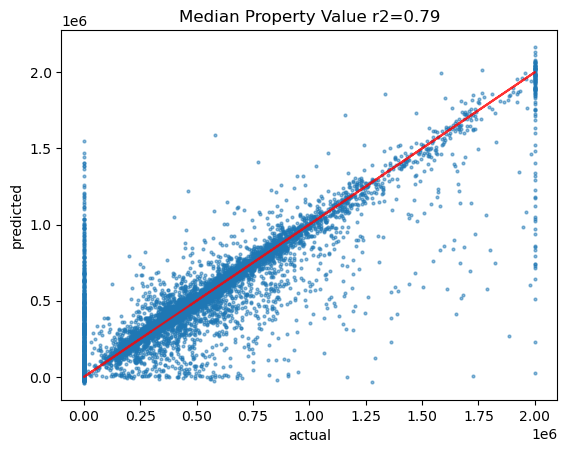

In [47]:
# 散点图
actual_ = [i*10000 for i in actual]
plt.scatter(actual_, predicted, s=4, alpha=0.5)
plt.plot(actual_, actual_, color = "red", alpha=0.8)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("Median Property Value r2=0.79")
plt.show()

In [50]:
loss = []
for i in range(0, len(predicted_)):
    tmp = (actual[i]-predicted_[i])**2
    loss.append(tmp)
print(len(loss))

9129


In [60]:
# 格式转换 结果从list格式转换为dataframe格式
tmp={"full_ct_fips" : lb,
   "predicted" : predicted, 
          "actual" : actual_, 
    "loss" : loss
    }#将列表lb，res转换成字典
df_=DataFrame(tmp)#将字典转换成为数据框
print(df_)

      full_ct_fips      predicted    actual       loss
0       6065042408  337165.222168  295300.0  17.526968
1       6077004203  253828.086853  241400.0   1.544573
2       6097154306    3800.776899       0.0   0.144459
3       6065047901   -3571.836054       0.0   0.127580
4       6097151308  572721.099854  556000.0   2.795952
...            ...            ...       ...        ...
9124    6037405400  453211.250305  433200.0   4.004501
9125    6099000913    -406.379886       0.0   0.001651
9126    6037320102    5579.479933       0.0   0.311306
9127    6067007207  374338.989258  308000.0  44.008615
9128    6037199110  506831.016541  472900.0  11.513139

[9129 rows x 4 columns]


In [62]:
df_.to_excel('result.xlsx', index=False) # 保存数据

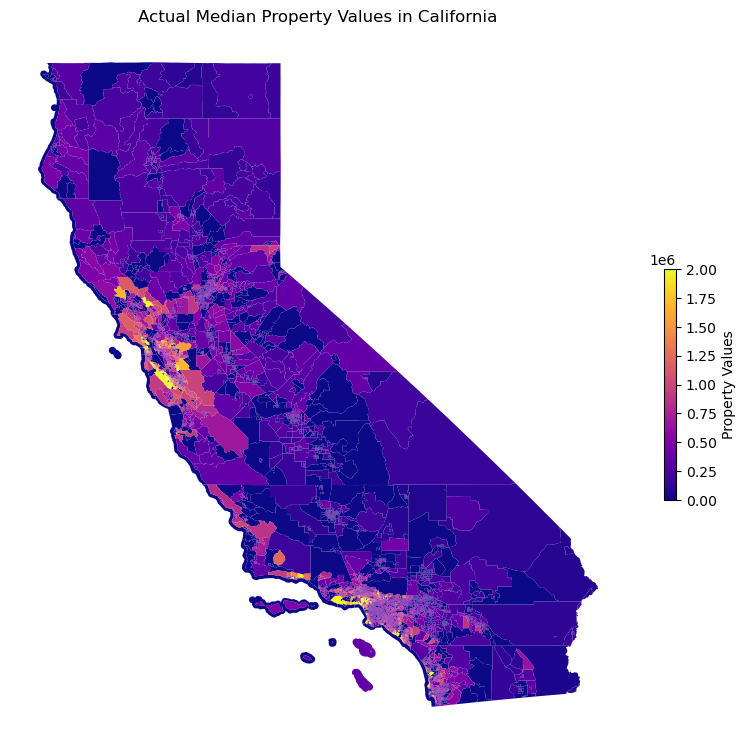

In [59]:
# 可视化结果比较
# 采用真实值（california_ct.csv文件中的值）绘图得到的结果
# read the data and shapefile
df = pd.read_csv('/kaggle/input/california-census-tract/California_ct.csv', index_col = 0)
california_shapefile = gpd.read_file('/kaggle/input/tl-2022-06-tract/tl_2022_06_tract/tl_2022_06_tract.shp') # read the shapefile
california_shapefile['GEOID'] = california_shapefile.GEOID.astype('int64') # 转为整型
df_shp = california_shapefile.merge(df,
                                 how = 'left',
                                 left_on = 'GEOID',
                                 right_on = 'full_ct_fips')  # 左连接 两个表通过GEOID连接起来 full_ct_fips就是GEOID
df_shp = df_shp.fillna(0.0) # 空的填0

# visualizing property values of the whole Florida
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis('off') # remove the axis
df_shp.plot(column = 'property_value_median', cmap = 'plasma', legend=True, vmin = 0, vmax = 2e6,
            legend_kwds={'label': "Property Values", 'orientation': "vertical", 'shrink': 0.3},
            ax = ax)
ax.set_title('Actual Median Property Values in California')

plt.tight_layout()
plt.show()

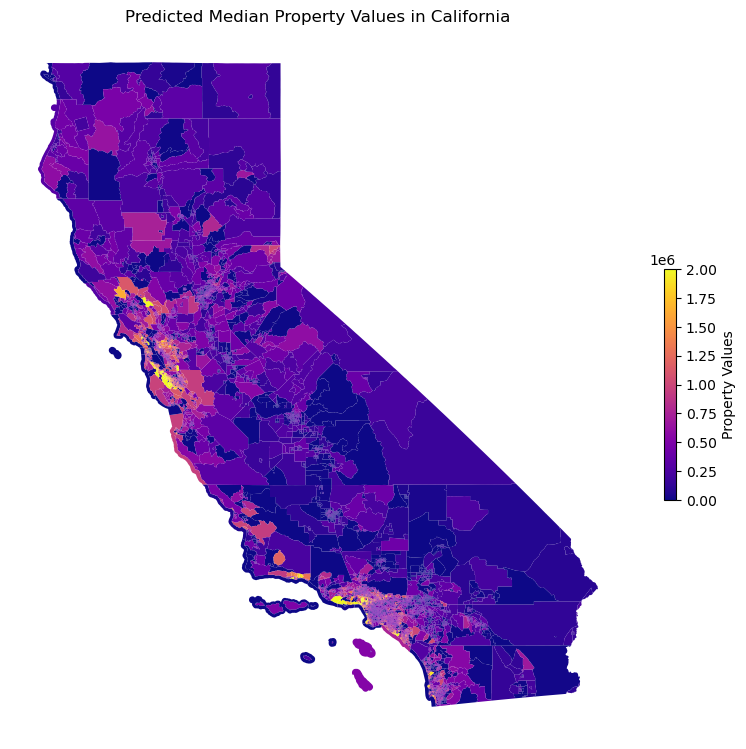

In [61]:
# 采用模型预测值得到的结果绘图
df_shp = california_shapefile.merge(df_,
                                 how = 'left',
                                 left_on = 'GEOID',
                                 right_on = 'full_ct_fips')  # 左连接 两个表通过GEOID连接起来 full_ct_fips就是GEOID
df_shp = df_shp.fillna(0.0) # 空的填0

fig, ax = plt.subplots(figsize=(8, 8))

ax.axis('off') # remove the axis
df_shp.plot(column = 'predicted', cmap = 'plasma', legend=True, vmin = 0, vmax = 2e6,
            legend_kwds={'label': "Property Values", 'orientation': "vertical", 'shrink': 0.3},
            ax = ax)
ax.set_title('Predicted Median Property Values in California')

plt.tight_layout()
plt.show()

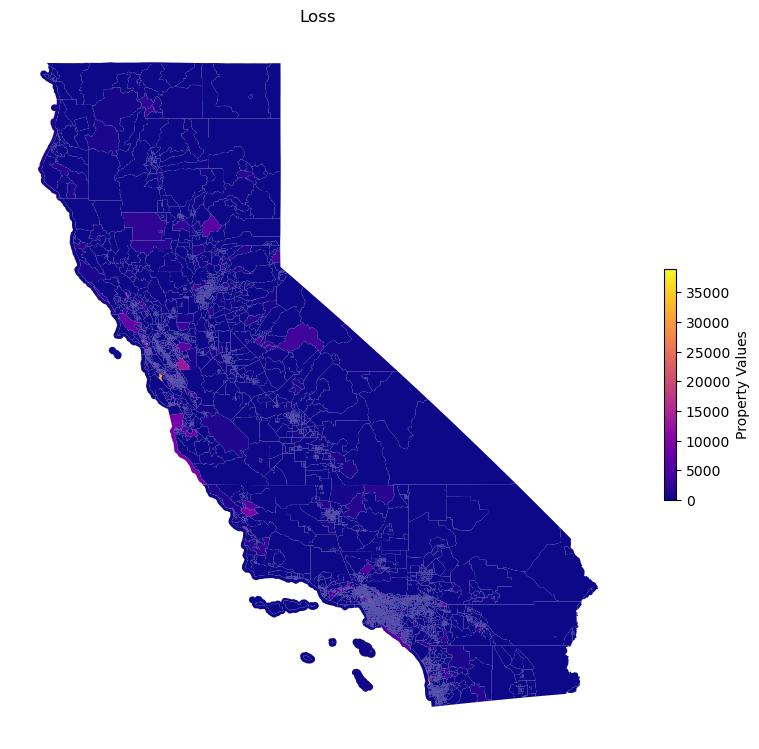

In [58]:
# loss
fig, ax = plt.subplots(figsize=(8, 8))

ax.axis('off') # remove the axis
df_shp.plot(column = 'loss', cmap = 'plasma', legend=True,
            legend_kwds={'label': "Property Values", 'orientation': "vertical", 'shrink': 0.3},
            ax = ax)
ax.set_title('Loss')

plt.tight_layout()
plt.show()